In [3]:
import numpy as np
import fitsio
import matplotlib.pyplot as plt
import os

In [4]:
dr_path = '/global/cfs/cdirs/desi/spectro/redux/iron/'
tiles = fitsio.read(os.path.join(dr_path, 'tiles-iron.fits'))

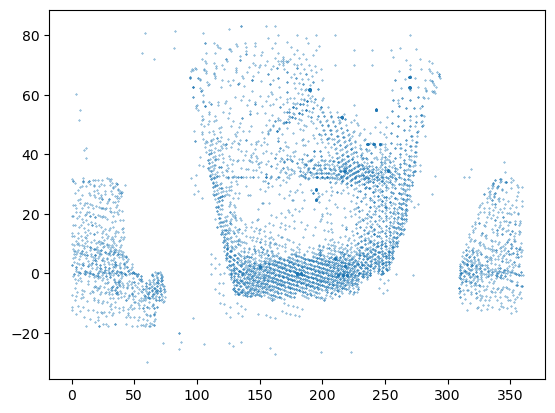

In [10]:
plt.scatter(tiles['TILERA'],tiles['TILEDEC'], s=0.1)

In [13]:
tiles_coords['theta'] = np.deg2rad(tiles['TILEDEC']-90.0)
tiles_coords['phi'] = np.deg2rad(360.0 - tiles['TILERA'])
tiles_coords['x'] = np.cos(tiles_coords['phi']) * np.sin(tiles_coords['theta'])
tiles_coords['y'] = np.sin(tiles_coords['phi']) * np.sin(tiles_coords['theta'])
tiles_coords['z'] = np.cos(tiles_coords['theta'])

In [18]:
ra_input=60.0
dec_input=40.0

def convert_radec_to_xyz(ra, dec):
    theta = np.deg2rad(dec-90.0)
    phi = np.deg2rad(360.0 - ra)
    x = np.cos(phi) * np.sin(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(theta)
    return phi, theta, x, y, z

In [20]:
tiles_coords = {}
out = convert_radec_to_xyz(tiles['TILERA'], tiles['TILEDEC'])
tiles_coords['phi'], tiles_coords['theta'], tiles_coords['x'], tiles_coords['y'], tiles_coords['z'] = out

In [84]:
def is_point_in_tiles(tiles_coords, ra_point, dec_point, tile_radius_deg=1.7):
    tile_radius_radians = tile_radius_deg*np.pi/180.0
    point = convert_radec_to_xyz(ra_point, dec_point)
    point_coords = {}
    point_coords['phi'], point_coords['theta'], point_coords['x'], point_coords['y'], point_coords['z'] = point
    #print(point_coords)
    cos_angle = np.zeros(len(tiles_coords['x']))
    #print(tiles_coords)
    for c in ['x', 'y', 'z']:
        cos_angle += tiles_coords[c]*point_coords[c]
    ii = cos_angle > np.cos(tile_radius_radians)
    if np.count_nonzero(ii)>0:
        return True
    else:
        return False

In [72]:
d = is_point_in_tiles(tiles_coords, 260.0, -20.0)
print(d)

{'phi': 1.7453292519943295, 'theta': -1.9198621771937625, 'x': 0.1631759111665348, 'y': -0.9254165783983234, 'z': -0.3420201433256687}
{'phi': array([5.86383505, 3.66309703, 5.6470477 , ..., 2.45468342, 1.21672138,
       1.45309132]), 'theta': array([-1.02293747, -1.53229436, -1.6493536 , ..., -1.40692736,
       -0.99804908, -1.16439641]), 'x': array([-0.77967681,  0.86642811, -0.80191559, ...,  0.76285141,
       -0.29139118, -0.10786844]), 'y': array([ 0.34757482,  0.4978159 ,  0.59226078, ..., -0.62565501,
       -0.78828234, -0.91219424]), 'z': array([ 0.52086065,  0.03849245, -0.0784765 , ...,  0.16313655,
        0.54194292,  0.39530504])}
False


In [109]:
def read_zcatalog(release='iron', version='v1'):
    dr_path = '/global/cfs/cdirs/desi/spectro/redux/{}/zcatalog/{}'.format(release, version)
    columns = ['TARGETID','Z', 'ZERR', 'ZWARN', 'SPECTYPE', 'TARGET_RA', 'TARGET_DEC', 'FLUX_G', 'FLUX_R', 'FLUX_Z']
    zcat = fitsio.read(os.path.join(dr_path, 'zall-pix-iron.fits'), columns=columns)
    ii = zcat['TARGETID']>0
    zcat = zcat[ii]
    return zcat
    

In [110]:
zcat = read_zcatalog()

In [116]:
def retrieve_region(zcat, ra, dec, radius_degrees, nearest=False):
    # read tiles
    dr_path = '/global/cfs/cdirs/desi/spectro/redux/iron/'
    tiles = fitsio.read(os.path.join(dr_path, 'tiles-iron.fits'))
    
    # convert coordinates
    tiles_coords = {}
    out = convert_radec_to_xyz(tiles['TILERA'], tiles['TILEDEC'])
    tiles_coords['phi'], tiles_coords['theta'], tiles_coords['x'], tiles_coords['y'], tiles_coords['z'] = out
    
    #point coordinates
    point = convert_radec_to_xyz(ra, dec)
    point_coords = {}
    point_coords['phi'], point_coords['theta'], point_coords['x'], point_coords['y'], point_coords['z'] = point
    
    if is_point_in_tiles(tiles_coords, ra, dec):
        print('point is in tiles')
        out = convert_radec_to_xyz(zcat['TARGET_RA'], zcat['TARGET_DEC'])
        zcat_coords = {}
        zcat_coords['phi'], zcat_coords['theta'], zcat_coords['x'], zcat_coords['y'], zcat_coords['z'] = out
        cos_angle = np.zeros(len(zcat_coords['x']))
        for c in ['x', 'y', 'z']:
            cos_angle += zcat_coords[c]*point_coords[c]
            
        if nearest:
            ii = np.argsort(cos_angle)
            return zcat[ii[-1]]
        else:
            ii = cos_angle > np.cos(np.deg2rad(radius_degrees))
            return zcat[ii]
    else:
        print('point is not in tiles')
        return None

In [126]:
data = retrieve_region(zcat, 200.2, 0.5, 0.1, nearest=True)

point is in tiles


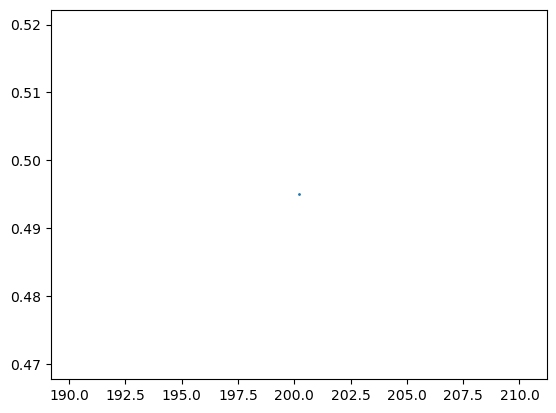

In [127]:
plt.scatter(data['TARGET_RA'], data['TARGET_DEC'], s=1.0)

In [128]:
len(data)

10

In [129]:
data

(39627800163914474, 1.18211983, 3.86908074e-05, 0, 'GALAXY', 200.20009927, 0.49496674, 0.27649733, 0.2685844, 0.5481903)